**Brian Blaylock**
**April 17, 2019**

# Both GOES-16 and GOES17 on the same map
For more details on plotting GOES ABI images in Python, visit the [Unidata Gallery](https://unidata.github.io/python-gallery/examples/mapping_GOES16_TrueColor.html#sphx-glr-examples-mapping-goes16-truecolor-py) and other notebooks in this [repository](https://github.com/blaylockbk/pyBKB_v3/blob/master/BB_GOES/).

GOES files can be downloaded from Amazon S3:
- Amazon page: https://registry.opendata.aws/noaa-goes/
- My download page: http://home.chpc.utah.edu/~u0553130/Brian_Blaylock/cgi-bin/generic_AWS_download.cgi?DATASET=noaa-goes16

In [1]:
import numpy as np
from datetime import datetime, timedelta
from pyproj import Proj
import pyproj
import xarray
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import sys

import metpy

#sys.path.append('../pyBKB_v3')
#rom BB_GOES.get_GOES import get_GOES_nearesttime

In [2]:
DATE = datetime(2019, 4, 17, 15)

# This functin gets the nearest file name and path on our local disk. 
# You might want to download GOES files from Amazon.
#file16 = get_GOES_nearesttime(DATE, product='ABI', satellite=16, verbose=False)
#file17 = get_GOES_nearesttime(DATE, product='ABI', satellite=17, verbose=False)

In [3]:
G16 = xarray.open_dataset('OR_ABI-L2-MCMIPC-M6_G16_s20191771701200_e20191771703573_c20191771704096.nc') #using metpy for reading satellite or weather data
G17 = xarray.open_dataset('OR_ABI-L2-MCMIPC-M6_G17_s20191771701197_e20191771703570_c20191771704070.nc')

In [4]:
def make_RGB(C, night_IR=True):
    """
    C        - GOES file opened with xarray
    night_IR - Set nighttime pixels as clean IR channel (channel 13, 10.3 um).
    """
    
    # Load the three channels into appropriate R, G, and B variables
    R = C['CMI_C02'].data
    G = C['CMI_C03'].data
    B = C['CMI_C01'].data

    ######################################################################
    #

    # Apply range limits for each channel. RGB values must be between 0 and 1
    R = np.clip(R, 0, 1)
    G = np.clip(G, 0, 1)
    B = np.clip(B, 0, 1)

    ######################################################################
    #

    # Apply a gamma correction to the image
    gamma = 2.2
    R = np.power(R, 1/gamma)
    G = np.power(G, 1/gamma)
    B = np.power(B, 1/gamma)

    ######################################################################
    #

    # Calculate the "True" Green
    G_true = 0.45 * R + 0.1 * G + 0.45 * B
    G_true = np.maximum(G_true, 0)
    G_true = np.minimum(G_true, 1)
    
    # The RGB array with the raw veggie band
    RGB_veggie = np.dstack([R, G, B])

    # The RGB array for the true color image
    RGB = np.dstack([R, G_true, B])
    
    if night_IR:
        cleanIR = C['CMI_C13'].data
        # Normalize the channel between a range. e.g. cleanIR =
        # (cleanIR-minimum)/(maximum-minimum)
        cleanIR = (cleanIR-90)/(313-90)

        # Apply range limits for each channel. RGB values must be between 0 and 1
        cleanIR = np.clip(cleanIR, 0, 1)

        # Invert colors so that cold clouds are white
        cleanIR = 1 - cleanIR

        # Lessen the brightness of the coldest clouds so they don't appear so bright
        # when we overlay it on the true color image
        cleanIR = cleanIR/1.4
    
        # Fill RGB where true color is black with IR values.
        RGB = np.dstack([np.maximum(R, cleanIR),
                         np.maximum(G_true, cleanIR),
                         np.maximum(B, cleanIR)])
        
    return RGB

In [5]:
# Make RGB for both GOES16 and GOES17
rgb16 = make_RGB(G16)
rgb17 = make_RGB(G17)

scan_start_16 = datetime.strptime(G16.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
scan_start_17 = datetime.strptime(G17.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')

/Users/michael/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in maximum
/Users/michael/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in minimum
/Users/michael/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in maximum
/Users/michael/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in maximum
/Users/michael/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in maximum


(-0.5, 2499.5, 1499.5, -0.5)

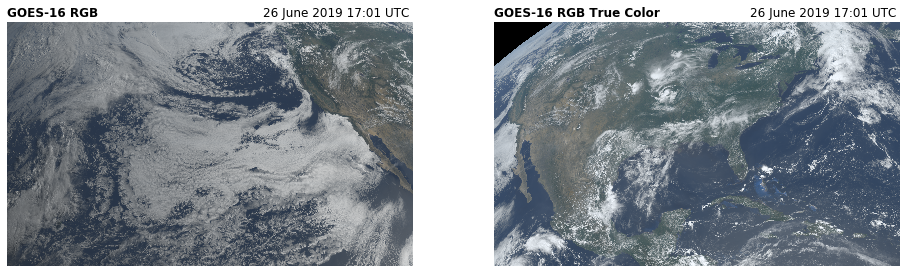

In [6]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))

# The GOES-17 RGB
ax1.imshow(rgb17)
ax1.set_title('GOES-16 RGB', fontweight='semibold', loc='left', fontsize=12);

ax1.set_title('%s' % scan_start_17.strftime('%d %B %Y %H:%M UTC '), loc='right');
ax1.axis('off')

# The GOES-16 RGB
ax2.imshow(rgb16)
ax2.set_title('GOES-16 RGB True Color', fontweight='semibold', loc='left', fontsize=12);
ax2.set_title('%s' % scan_start_16.strftime('%d %B %Y %H:%M UTC '), loc='right');
ax2.axis('off')

In [7]:
# Generate cartopy projection object with metpy parser
# NOTE: Don't re-run this cell after it has run or it won't work.
dat16 = G16.metpy.parse_cf('CMI_C02')
dat17 = G17.metpy.parse_cf('CMI_C02')

# Geostationary projections
geos16 = dat16.metpy.cartopy_crs
geos17 = dat17.metpy.cartopy_crs

In [8]:
x16 = dat16.x
y16 = dat16.y

x17 = dat17.x
y17 = dat17.y

In [9]:
print(float(x16.min()))

-3626269.332309611


In [10]:
pc = ccrs.PlateCarree()

# Plot Geostationary figures

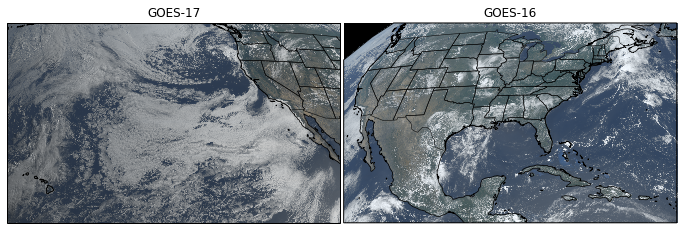

In [11]:
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1, projection=geos17)
ax2 = fig.add_subplot(1, 2, 2, projection=geos16)


## GOES 17
ax1.imshow(rgb17, origin='upper', extent=(x17.min(), x17.max(), y17.min(), y17.max()),
           transform=geos17)
ax1.coastlines(resolution='50m', color='black', linewidth=.75)
ax1.add_feature(ccrs.cartopy.feature.STATES, linewidth=.5)
ax1.set_title('GOES-17')

## GOES 16
ax2.imshow(rgb16, origin='upper', extent=(x16.min(), x16.max(), y16.min(), y16.max()),
           transform=geos16)
ax2.coastlines(resolution='50m', color='black', linewidth=.75)
ax2.add_feature(ccrs.cartopy.feature.STATES, linewidth=.5)
ax2.set_title('GOES-16')

fig.subplots_adjust(wspace=.01)

# Lambert Conformal

Transforming the image on the LCC projection takes a long time if you try making the full image size, especially if there is a large area of no data (white space on map).

### Tips for faster plotting:
- **Sacrafice resolution** by downsampling the RGB array `RGB[::20,::20]` would only plot every 20th item. This decreases plotting time significantly and would be useful for quick plots. Simply downscaling in half, i.e. `RGB[::2,::2]`, is more than twice as fast as plotting the full resolution.
- **Zoom** in on an area of interest. For some reason, by zooming into smaller areas, such as a single state, reduces the time it takes to plot. It is best to scale down the image to what you want by showing a smaller domain by with `ax.set_extent()`.

> Setting `interpolation='none'` in `imshow` doesn't seem to do anything.

0:00:03.107104
0:00:03.094000


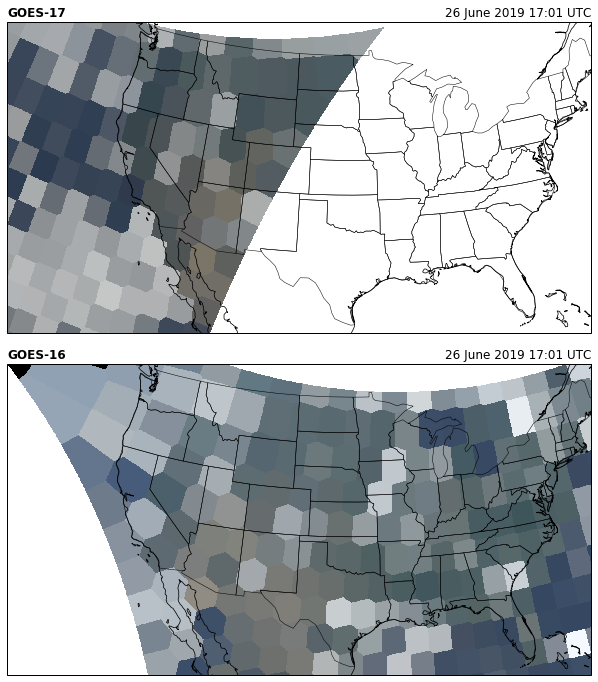

In [12]:
# Downsampling the image makes it faster to plot large areas
thin = 100


fig = plt.figure(figsize=[12, 12])


lc = ccrs.LambertConformal(central_longitude = -97.5,
                           standard_parallels = (38.5, 38.5))

ax1 = fig.add_subplot(2, 1, 1, projection=lc)
ax2 = fig.add_subplot(2, 1, 2, projection=lc)

ax1.set_extent([-130, -75, 25, 48], crs=pc)
ax2.set_extent([-130, -75, 25, 48], crs=pc)

#ax1.set_extent([-155, -70, 20, 45], crs=pc)
#ax1.set_extent([-122.72, -72.29, 24.36, 50.45], crs=pc) # HRRR


# GOES17
timer = datetime.now()
ax1.imshow(rgb17[::thin,::thin], origin='upper',
           extent=(x17.min(), x17.max(), y17.min(), y17.max()),
           transform=geos17, 
           interpolation='none')
print(datetime.now()-timer)
ax1.coastlines(resolution='50m', color='black', linewidth=0.75)
ax1.add_feature(ccrs.cartopy.feature.STATES, linewidth=0.5)
ax1.set_title('GOES-17', loc='left', fontweight='bold')
ax1.set_title('%s' % scan_start_17.strftime('%d %B %Y %H:%M UTC'), loc='right');


# GOES16
# The imshow transform seems to take a long time
timer = datetime.now()
ax2.imshow(rgb16[::thin,::thin], origin='upper',
           extent=(x16.min(), x16.max(), y16.min(), y16.max()),
           transform=geos16,
           interpolation='none')
print(datetime.now()-timer)

ax2.coastlines(resolution='50m', color='black', linewidth=0.75)
ax2.add_feature(ccrs.cartopy.feature.STATES, linewidth=0.5)
ax2.set_title('GOES-16', loc='left', fontweight='bold')
ax2.set_title('%s' % scan_start_16.strftime('%d %B %Y %H:%M UTC'), loc='right');


fig.subplots_adjust(hspace=.1)

thin:  2
0:00:03.924310
0:00:04.929557


Text(0.5, 1.0, 'GOES-17 Overlaid on GOES-16')

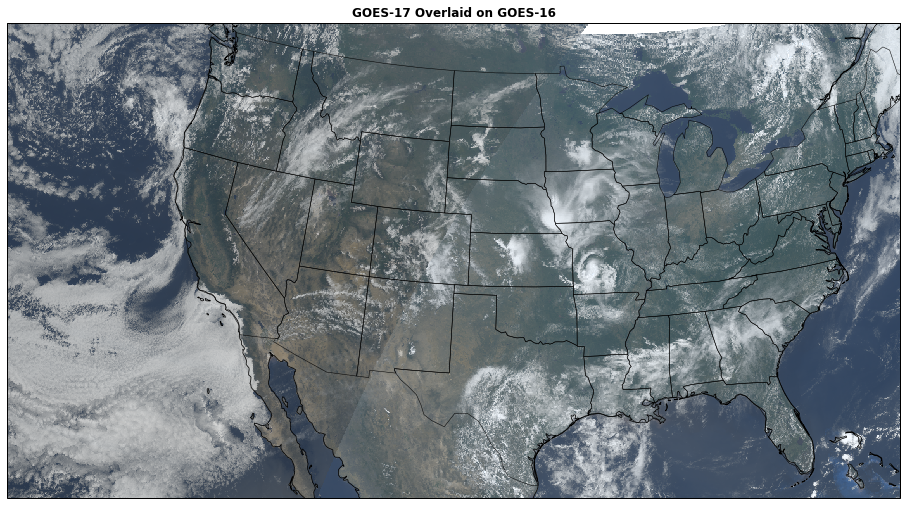

In [13]:
# Downsampling the image makes it faster to plot large areas
thin = 2
print("thin: ", thin)

fig = plt.figure(figsize=[16, 12])


lc = ccrs.LambertConformal(central_longitude = -97.5,
                           standard_parallels = (38.5, 38.5))

ax3 = fig.add_subplot(1, 1, 1, projection=lc)
ax3.set_extent([-130, -75, 25, 48], crs=pc)

# GOES16 + GOES17

# The imshow transform seems to take a long time
timer = datetime.now()
ax3.imshow(rgb16[::thin,::thin], origin='upper',
           extent=(x16.min(), x16.max(), y16.min(), y16.max()),
           transform=geos16,
           interpolation='none')
print(datetime.now()-timer)

timer = datetime.now()
ax3.imshow(rgb17[::thin,::thin], origin='upper',
           extent=(x17.min(), x17.max(), y17.min(), y17.max()),
           transform=geos17,
           interpolation='none')
print(datetime.now()-timer)

ax3.coastlines(resolution='50m', color='black', linewidth=0.75)
ax3.add_feature(ccrs.cartopy.feature.STATES, linewidth=0.5)

plt.title('GOES-17 Overlaid on GOES-16', fontweight='bold')

# Plate Carree Cylindrical Projection
Zoomed on Utah

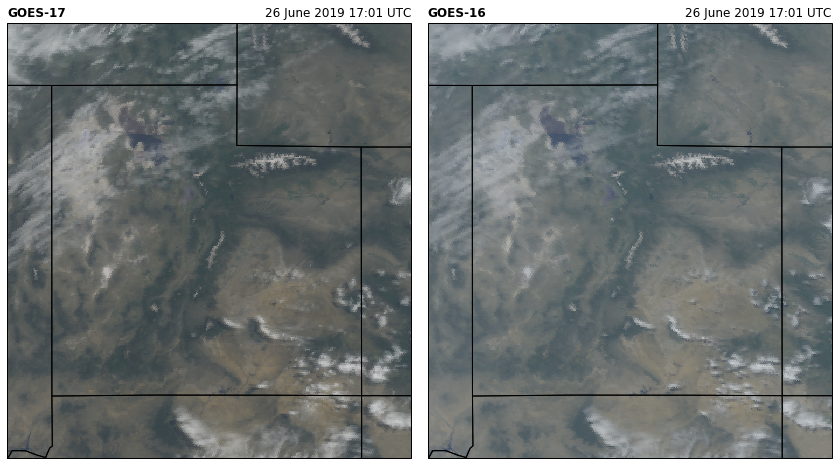

In [14]:
fig = plt.figure(figsize=(15, 8))

ax1 = fig.add_subplot(1, 2, 1, projection=pc)
ax2 = fig.add_subplot(1, 2, 2, projection=pc)

ax1.set_extent([-114.75, -108.25, 36, 43], crs=pc)
ax2.set_extent([-114.75, -108.25, 36, 43], crs=pc)


# GOES17
ax1.imshow(rgb17, origin='upper',
           extent=(x17.min(), x17.max(), y17.min(), y17.max()),
           transform=geos17,
           interpolation='none')
ax1.add_feature(ccrs.cartopy.feature.STATES)
ax1.set_title('GOES-17', loc='left', fontweight='bold')
ax1.set_title('%s' % scan_start_17.strftime('%d %B %Y %H:%M UTC'), loc='right');

# GOES16
ax2.imshow(rgb16, origin='upper',
           extent=(x16.min(), x16.max(), y16.min(), y16.max()),
           transform=geos16,
           interpolation='none')
ax2.add_feature(ccrs.cartopy.feature.STATES)
ax2.set_title('GOES-16', loc='left', fontweight='bold')
ax2.set_title('%s' % scan_start_16.strftime('%d %B %Y %H:%M UTC'), loc='right');


fig.subplots_adjust(wspace=.01)

In [15]:
# fig = plt.figure(figsize=(15, 8))

# ax1 = fig.add_subplot(1, 2, 1, projection=pc)
# ax2 = fig.add_subplot(1, 2, 2, projection=pc)

# ax1.set_extent([-114.75, -108.25, 36, 43], crs=pc)
# ax2.set_extent([-114.75, -108.25, 36, 43], crs=pc)


In [16]:
[float(x16.min()), float(x16.max()),float(y16.min()), float(y16.max())]

[-3626269.332309611, 1381769.9431296065, 1584175.830644913, 4588197.756226748]

In [17]:
prj = pyproj.Proj("+proj=eqc +units=m") 
a = prj(-114.75, 36) # lower left coordinates
b = prj(-108.25, 43) # upper right coordinates
extent = a + b
print(extent)

(-12773911.568528144, 4007501.6685578483, -12050334.878371863, 4786738.104110763)


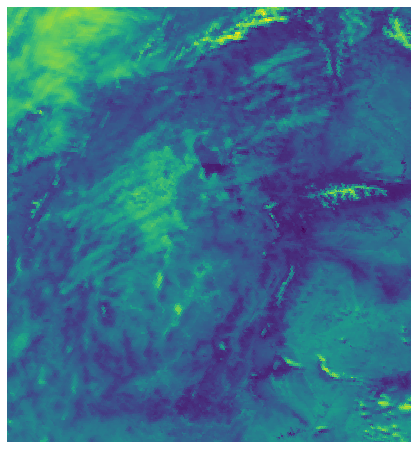

In [18]:
geos16 = dat16.metpy.cartopy_crs

# ax2 = fig.add_subplot(1, 2, 2, projection=pc)

# ax1.set_extent([-114.75, -108.25, 36, 43], crs=pc)
# ax2.set_extent([-114.75, -108.25, 36, 43], crs=pc)
R16 = rgb16[:,:,0]
from pyresample import image, geometry
prj = pyproj.Proj("+proj=eqc +units=m") 
a = prj(-114.75, 36) # lower left coordinates
b = prj(-108.25, 43) # upper right coordinates
extent = a + b
goes16_area = geometry.AreaDefinition('GOES-16', 'CONUS',
                                'GOES-16',
                                {'a': 6378137.0,
                                 'b': 6356752.31414,
                                 'rf': 298.2572221,
                                 'proj': 'geos',
                                 'lon_0': -75.0,
                                 'lat_0': 0.0,
                                'h': 35786023.0,
                                 'x_0': 0,
                                 'y_0': 0,
                                 'units': 'm',
                                 'sweep': 'x'},
                                R16.shape[1], R16.shape[0],
                              [float(x16.min()), float(x16.max()),float(y16.min()), float(y16.max())])
area_pc_def = geometry.AreaDefinition('areaD', 'CONUS-UTAH', 'areaD',
                                  {'ellps': 'WGS84',
                                   'proj': 'eqc', 
                                   'lon_0': 0},
                                    800, 800,
                                   extent)
geos16_con_nn = image.ImageContainerNearest(R16, goes16_area, radius_of_influence=50000)
area_con_nn = geos16_con_nn.resample(area_pc_def)
image_pc = area_con_nn.image_data
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(1, 1, 1, projection=pc)
#ax1.set_extent([-114.75, -108.25, 36, 43], crs=pc)
ax1.add_feature(ccrs.cartopy.feature.STATES)
ax1.imshow(image_pc,extent = (extent[0],extent[2],extent[1],extent[3]), origin='upper',transform=pc)

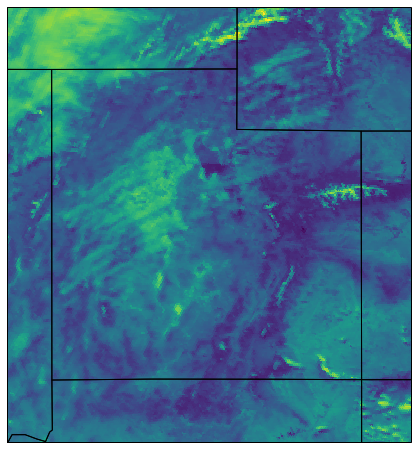

In [19]:
geos16 = dat16.metpy.cartopy_crs

# ax2 = fig.add_subplot(1, 2, 2, projection=pc)

# ax1.set_extent([-114.75, -108.25, 36, 43], crs=pc)
# ax2.set_extent([-114.75, -108.25, 36, 43], crs=pc)
R16 = rgb16[:,:,0]
from pyresample import image, geometry
prj = pyproj.Proj("+proj=eqc +units=m") 
a = prj(-114.75, 36) # lower left coordinates
b = prj(-108.25, 43) # upper right coordinates
extent = a + b
goes16_area = geometry.AreaDefinition('GOES-16', 'CONUS',
                                'GOES-16',
                                {'a': 6378137.0,
                                 'b': 6356752.31414,
                                 'rf': 298.2572221,
                                 'proj': 'geos',
                                 'lon_0': -75.0,
                                 'lat_0': 0.0,
                                'h': 35786023.0,
                                 'x_0': 0,
                                 'y_0': 0,
                                 'units': 'm',
                                 'sweep': 'x'},
                                R16.shape[1], R16.shape[0],
                              [float(x16.min()), float(x16.max()),float(y16.min()), float(y16.max())])
area_pc_def = geometry.AreaDefinition('areaD', 'CONUS-UTAH', 'areaD',
                                  {'ellps': 'WGS84',
                                   'proj': 'eqc', 
                                   'lon_0': 0},
                                    800, 800,
                                   extent)
geos16_con_nn = image.ImageContainerNearest(R16, goes16_area, radius_of_influence=50000)
area_con_nn = geos16_con_nn.resample(area_pc_def)
image_pc = area_con_nn.image_data
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(1, 1, 1, projection=pc)
ax1.set_extent([-114.75, -108.25, 36, 43])
ax1.imshow(image_pc,extent = [-114.75, -108.25, 36, 43], origin='upper')
ax1.add_feature(ccrs.cartopy.feature.STATES)

In [20]:
print(x16.min().shape, x16.max(),y16.min(), y16.max())


() <xarray.DataArray 'x' ()>
array(1381769.94313)
Coordinates:
    t        datetime64[ns] 2019-06-26T17:02:38.710263936
    y_image  float64 3.086e+06
    x_image  float64 -1.122e+06
    crs      object Projection: geostationary <xarray.DataArray 'y' ()>
array(1584175.830645)
Coordinates:
    t        datetime64[ns] 2019-06-26T17:02:38.710263936
    y_image  float64 3.086e+06
    x_image  float64 -1.122e+06
    crs      object Projection: geostationary <xarray.DataArray 'y' ()>
array(4588197.756227)
Coordinates:
    t        datetime64[ns] 2019-06-26T17:02:38.710263936
    y_image  float64 3.086e+06
    x_image  float64 -1.122e+06
    crs      object Projection: geostationary


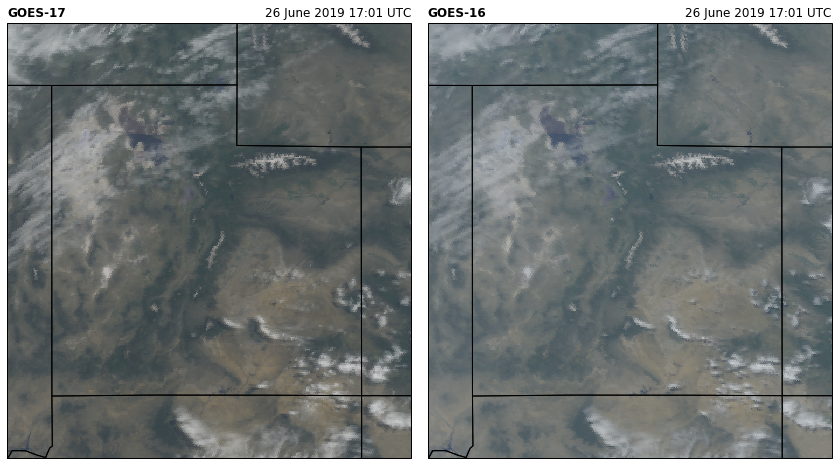

In [21]:
fig = plt.figure(figsize=(15, 8))

ax1 = fig.add_subplot(1, 2, 1, projection=pc)
ax2 = fig.add_subplot(1, 2, 2, projection=pc)

ax1.set_extent([-114.75, -108.25, 36, 43], crs=pc)
ax2.set_extent([-114.75, -108.25, 36, 43], crs=pc)


# GOES17
ax1.imshow(rgb17, origin='upper',
           extent=(x17.min(), x17.max(), y17.min(), y17.max()),
           transform=geos17,
           interpolation='none')
ax1.add_feature(ccrs.cartopy.feature.STATES)
ax1.set_title('GOES-17', loc='left', fontweight='bold')
ax1.set_title('%s' % scan_start_17.strftime('%d %B %Y %H:%M UTC'), loc='right');

# GOES16
ax2.imshow(rgb16, origin='upper',
           extent=(x16.min(), x16.max(), y16.min(), y16.max()),
           transform=geos16,
           interpolation='none')
ax2.add_feature(ccrs.cartopy.feature.STATES)
ax2.set_title('GOES-16', loc='left', fontweight='bold')
ax2.set_title('%s' % scan_start_16.strftime('%d %B %Y %H:%M UTC'), loc='right');


fig.subplots_adjust(wspace=.01)

In [22]:
import pyresample

In [23]:
help(pyresample.geometry)

Help on module pyresample.geometry in pyresample:

NAME
    pyresample.geometry - Classes for geometry operations

CLASSES
    builtins.ValueError(builtins.Exception)
        DimensionError
        IncompatibleAreas
    builtins.object
        BaseDefinition
            AreaDefinition
            CoordinateDefinition
                GridDefinition
                SwathDefinition
            StackedAreaDefinition
        DynamicAreaDefinition
    
    class AreaDefinition(BaseDefinition)
     |  AreaDefinition(area_id, description, proj_id, projection, width, height, area_extent, rotation=None, nprocs=1, lons=None, lats=None, dtype=<class 'numpy.float64'>)
     |  
     |  Holds definition of an area.
     |  
     |  Parameters
     |  ----------
     |  area_id : str
     |      Identifier for the area
     |  description : str
     |      Human-readable description of the area
     |  proj_id : str
     |      ID of projection
     |  projection: dict or str
     |      Dictionary or

In [24]:
geos16.proj4_params

{'a': 6378137.0,
 'b': 6356752.31414,
 'rf': 298.2572221,
 'proj': 'geos',
 'lon_0': -75.0,
 'lat_0': 0.0,
 'h': 35786023.0,
 'x_0': 0,
 'y_0': 0,
 'units': 'm',
 'sweep': 'x'}

In [25]:
geos17.proj4_params

{'a': 6378137.0,
 'b': 6356752.31414,
 'rf': 298.2572221,
 'proj': 'geos',
 'lon_0': -137.0,
 'lat_0': 0.0,
 'h': 35786023.0,
 'x_0': 0,
 'y_0': 0,
 'units': 'm',
 'sweep': 'x'}

In [26]:
pc.proj4_params

{'ellps': 'WGS84', 'a': 57.29577951308232, 'proj': 'eqc', 'lon_0': 0.0}

In [56]:
geos16 = dat16.metpy.cartopy_crs
geos17 = dat17.metpy.cartopy_crs

R16 = rgb16[:,:,0]
R17 = rgb17[:,:,0]

from pyresample import image, geometry
prj = pyproj.Proj("+proj=eqc +units=m") 
a = prj(-114.75, 36) # lower left coordinates
b = prj(-108.25, 43) # upper right coordinates
extent = a + b
goes16_area = geometry.AreaDefinition('GOES-16', 'CONUS',
                                'GOES-16',
                                {'a': 6378137.0,
                                 'b': 6356752.31414,
                                 'rf': 298.2572221,
                                 'proj': 'geos',
                                 'lon_0': -75.0,
                                 'lat_0': 0.0,
                                'h': 35786023.0,
                                 'x_0': 0,
                                 'y_0': 0,
                                 'units': 'm',
                                 'sweep': 'x'},
                                R16.shape[1], R16.shape[0],
                              [float(x16.min()), float(x16.max()),float(y16.min()), float(y16.max())])
goes17_area = geometry.AreaDefinition('GOES-17', 'CONUS',
                                'GOES-17',
                                {'a': 6378137.0,
                                 'b': 6356752.31414,
                                 'rf': 298.2572221,
                                 'proj': 'geos',
                                 'lon_0': -137.0,
                                 'lat_0': 0.0,
                                 'h': 35786023.0,
                                 'x_0': 0,
                                 'y_0': 0,
                                 'units': 'm',
                                 'sweep': 'x'},
                                R17.shape[1], R17.shape[0],
                              [float(x17.min()), float(x17.max()),float(y17.min()), float(y17.max())])
area_pc_def_16 = geometry.AreaDefinition('areaD', 'CONUS-UTAH', 'areaD',
                                  {'ellps': 'WGS84',
                                   'proj': 'eqc', 
                                   'lon_0': 0},
                                    800, 800,
                                   extent)
area_pc_def_17 = geometry.AreaDefinition('areaD', 'CONUS-UTAH', 'areaD',
                                  {'ellps': 'WGS84',
                                   'proj': 'eqc', 
                                   'lon_0': 0},
                                    800, 800,
                                   extent)
# geos16_con_nn = image.ImageContainerNearest(R16, goes16_area, radius_of_influence=50000)
# area16_con_nn = geos16_con_nn.resample(area_pc_def_16)
# image_pc_16 = area16_con_nn.image_data

geos17_con_nn = image.ImageContainerNearest(R17, goes17_area, radius_of_influence=50000)
area17_con_nn = geos17_con_nn.resample(area_pc_def_17)
image_pc_17 = area17_con_nn.image_data

In [52]:
image_pc_17.max()

0.0

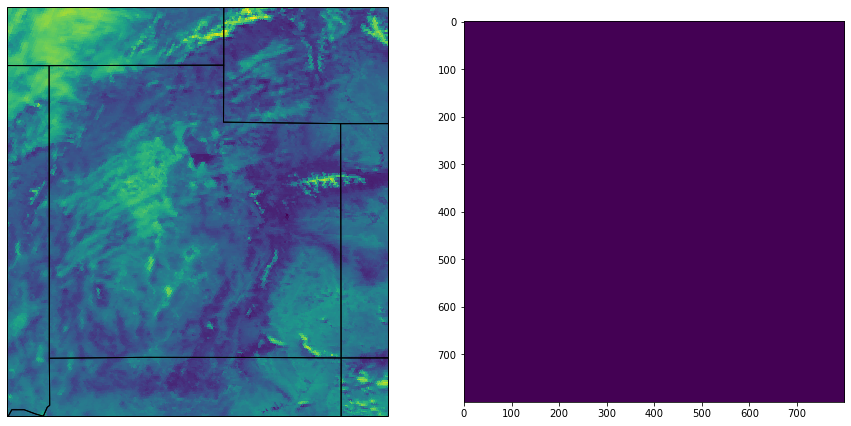

In [57]:
fig = plt.figure(figsize=(15, 8))

ax1 = fig.add_subplot(1, 2, 1, projection=pc)
ax2 = fig.add_subplot(1, 2, 2)

ax1.set_extent([-114.75, -108.25, 36, 43], crs=pc)
ax1.imshow(image_pc_16,extent = [-114.75, -108.25, 36, 43], origin='upper')
ax1.add_feature(ccrs.cartopy.feature.STATES)
ax2.imshow(image_pc_17, origin='upper')
#ax2.add_feature(ccrs.cartopy.feature.STATES)